In [2]:
# %env LDFLAGS=-L/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/lib

env: LDFLAGS=-L/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/lib


In [1]:
import argparse, time
from argparse import Namespace
import os
import torch
from tqdm import tqdm
import numpy as np
import sys
from PIL import Image
from models.psp import pSp
# from psp.models import pSp
import torchvision.transforms as transforms
from torchvision import utils
from collections import OrderedDict
# from tools.common import trans
from utils.common import tensor2im, log_input_image



In [12]:
    
def get_latent_repr(weight_path, img_path):
    print(f"Loading model at path -> {weight_path}")

    # update test options with options used during training
    ckpt = torch.load(weight_path, map_location='cpu')
    opts = ckpt['opts']
    
    opts['checkpoint_path'] = weight_path
    opts['device'] = "cpu"

    # opts.update(vars(test_opts))
    if 'learn_in_w' not in opts:
        opts['learn_in_w'] = False
    if 'output_size' not in opts:
        opts['output_size'] = 1024
    opts = Namespace(**opts)

    net = pSp(opts)
    net.eval()
    # net.cuda()

    print("model ready for inference")


    trans = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])




    # Load input image and resize to the right format
    original_image1 = Image.open(img_path)
    original_image1 = original_image1.convert("RGB")
    original_image1.resize((256, 256))
    input_image1 = original_image1

    # Transformers input image into format needed for model from the pre-process pipeline
    transformed_image1 = trans(input_image1)


    with torch.no_grad():
        tic = time.time()
        result_image_pt, result_vector1 = net(transformed_image1.unsqueeze(0),
                                              randomize_noise=False, 
                                              return_latents=True) 
        toc = time.time()
        print('Inference took {:.4f} seconds.'.format(toc - tic))
        return result_image_pt, result_vector1, original_image1

In [22]:
weight_path = './weights/psp_mobile.pt'
img_path = './test_images/dongyun.jpg'



result_image_pt, result_vector1, og_img = get_latent_repr(weight_path, img_path)

Loading model at path -> ./weights/psp_mobile.pt
Loading pSp from checkpoint: ./weights/psp_mobile.pt
model ready for inference
Inference took 3.1760 seconds.


In [10]:
# I adjusted the default implementation of tensor2im to not use "to.device()", since it's in tf now
def tensor2img2(image_tensor, imtype=np.uint8, normalize=True):
    if normalize:
        image_numpy = (np.transpose(image_tensor, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = np.transpose(image_tensor, (1, 2, 0)) * 255.0     
    image_numpy = np.clip(image_numpy, 0, 255)
    if image_numpy.shape[2] == 1 or image_numpy.shape[2] > 3:       
        image_numpy = image_numpy[:,:,0]
    return image_numpy.numpy().astype(imtype)


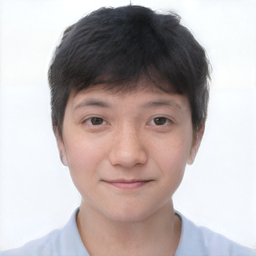

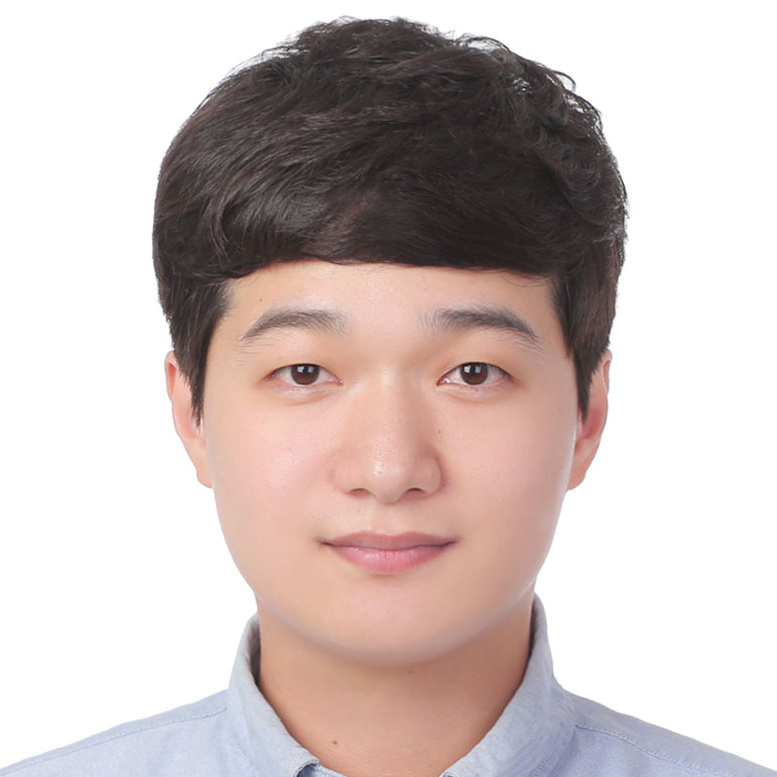

In [23]:


# result_image = tensor2im(result_image_pt[0])
# res = np.concatenate([np.array(result_image_pt[0].resize((256, 256))),
#                         np.array(og_img.resize((256, 256)))], axis=1)
# res_im = Image.fromarray(res)
# res_im
# 
# Reverts all preprocessing on resulting image to get to normal format
img_arr = tensor2img2(result_image_pt[0])

# Formats image vec to actual image
img_match = Image.fromarray(img_arr)
display(img_match)


og_img
    